### Инструкция по выполнению проекта:

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.


#### Описание данных
Таблица visits (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

# Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info.csv
 -   /datasets/orders_info.csv
 -   /datasets/costs_info.csv

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
observation_date = datetime(2020, 1, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

In [2]:
visits = pd.read_csv('visits_info.csv')
orders = pd.read_csv('orders_info.csv')
costs = pd.read_csv('costs_info.csv')

Переименую столбцы для удобства 

In [3]:
visits.columns = (visits.columns.str.lower()).str.replace(' ', '_')
orders.columns = (orders.columns.str.lower()).str.replace(' ', '_')
costs.columns = (costs.columns.str.lower()).str.replace(' ', '_')

In [4]:
visits.info(), orders.info(), costs.info() # пропусков нет, но необходимо даты перевести в нужный формат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null object
session_end      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null object
revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


(None, None, None)

In [5]:
visits.duplicated().sum(), orders.duplicated().sum(), costs.duplicated().sum()

(0, 0, 0)

In [6]:
# преобразование данных о времени
time_format = '%d.%m.%Y %H:%M'

visits['session_start'] = pd.to_datetime(visits['session_start'], format = time_format)
visits['session_end'] = pd.to_datetime(visits['session_end'], format = time_format)
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

# Шаг 2. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [7]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [8]:
# создаю профили
profiles = get_profiles(visits, orders, costs)

In [9]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Подавляющее большинство платящих пользователей из США

In [10]:
profiles.groupby('region').agg({'payer':'sum'})

,payer
region,
France,663.0
Germany,616.0
UK,700.0
United States,6902.0


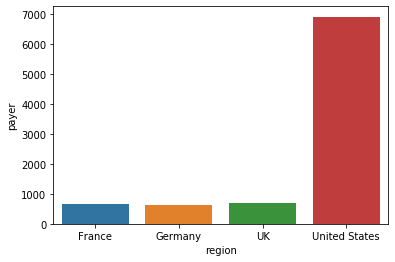

In [11]:
sns.barplot(x='region' , y='payer', data=profiles.groupby('region').agg({'payer':'sum'}).reset_index())

В основном пользователи айфонов


In [12]:
profiles.groupby('device').agg({'payer':'sum'})

,payer
device,
Android,2050.0
Mac,1912.0
PC,1537.0
iPhone,3382.0


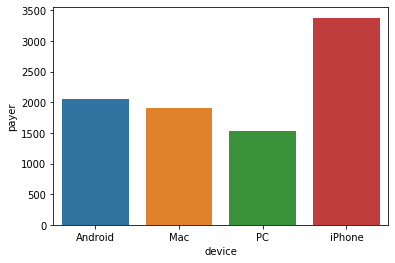

In [13]:
sns.barplot(x='device' , y='payer', data=profiles.groupby('device').agg({'payer':'sum'}).reset_index())

Пришли из FaceBoom

In [14]:
profiles.groupby('channel').agg({'payer':'sum'})

,payer
channel,
AdNonSense,440.0
FaceBoom,3557.0
LeapBob,262.0
MediaTornado,156.0
OppleCreativeMedia,233.0
RocketSuperAds,352.0
TipTop,1878.0
WahooNetBanner,453.0
YRabbit,165.0


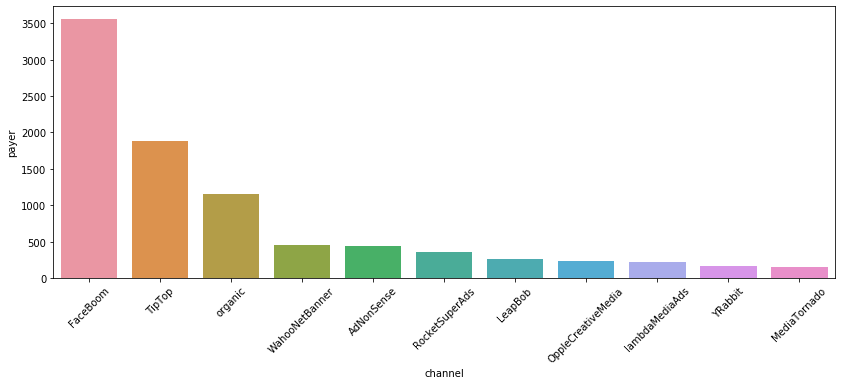

In [15]:
plt.figure(figsize=(14,5))
sns.barplot(x='channel' , y='payer', data=profiles.groupby('channel').agg({'payer':'sum'}).reset_index().sort_values(by='payer', ascending=False))
plt.xticks(rotation=45);

In [16]:
profiles.groupby('region').agg({'payer':'sum'}) / profiles.groupby('region').agg({'payer':'count'}) 

,payer
region,
France,0.037994
Germany,0.041119
UK,0.039829
United States,0.069019


In [17]:
profiles.payer.cumsum()

0            1
1            1
2            1
3            1
4            1
          ... 
150003    8881
150004    8881
150005    8881
150006    8881
150007    8881
Name: payer, Length: 150008, dtype: int64

In [18]:
profiles.groupby('region').agg({'payer':'cumsum'})

,payer
0,1.0
1,1.0
2,0.0
3,0.0
4,1.0
...,...
150003,6902.0
150004,700.0
150005,6902.0
150006,6902.0


Доля платящих пользователей небольшая, 5.9% но среди пользователей сша она выше 6.9%

In [19]:
profiles.payer.sum() / profiles.payer.count()

0.05920350914617887

**Вывод:**

Пользователи США являются основной аудиторией, их не только подавляющее большинство, но и процент платящих среди них выше. Ну и так как пользователи США основная аудитория, то пользователей айфонов больше, чем андоидов а маков больше, чем ПК.

# Шаг 3. Постройте отчёты и посчитайте метрики
Продукт:

-    Сколько людей пользуются в день, неделю, месяц?
-    Сколько сессий в день?
-    Сколько длится одна сессия?

Продажи:

- Когда люди начинают покупать?
- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?
- Какой средний чек за месяц, неделю, день?

Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [20]:
visits['session_date'] = visits['session_start'].dt.date 
visits['session_week'] = visits['session_start'].dt.week 
visits['session_month'] = visits['session_start'].dt.month

### Продукт:
-    Сколько людей пользуются в день, неделю, месяц?

In [21]:
visits.groupby('session_date').agg({'user_id':"nunique"}).mean()

user_id    1684.23913
dtype: float64

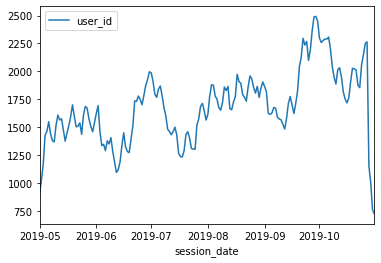

In [22]:
#Пользователей в день
visits.groupby('session_date').agg({'user_id':"nunique"}).plot()

In [23]:
#Среднее количество пользователей в неделю
visits.groupby('session_week').agg({'user_id':"nunique"}).mean()

user_id    8353.777778
dtype: float64

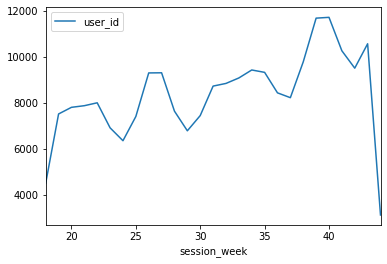

In [24]:

visits.groupby('session_week').agg({'user_id':"nunique"}).plot()

In [25]:
#в месяц
visits.groupby('session_month').agg({'user_id':"nunique"}).mean()

user_id    28989.166667
dtype: float64

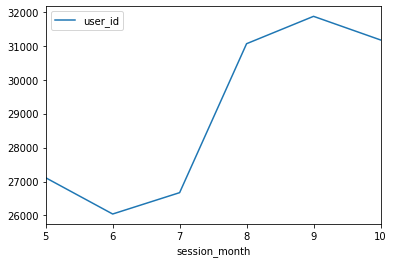

In [26]:
visits.groupby('session_month').agg({'user_id':"nunique"}).plot()

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера:</b> Верные расчеты для DAU, WAU и MAU.</div>

Виден тренд на увеличение количества пользователей, падения в конце можно объяснить то что день, месяц и неделя не полные. 

<div class="alert alert-danger">
<b>❌ Комментарий ревьюера:</b> Какие выводы можно сделать, исходя из полученных графиков?  

</div>

<div class="alert alert-info"> <b>Комментарий ревьюера:</b> Вывод верный. Обрыв данных говорит о том, что наши данные ограничены.</div>

-    Сколько сессий в день?

In [27]:
visits.groupby('session_date').agg({'session_date':"count"}).mean()

session_date    1684.244565
dtype: float64

Text(0, 0.5, 'Количество')

<Figure size 1008x360 with 0 Axes>

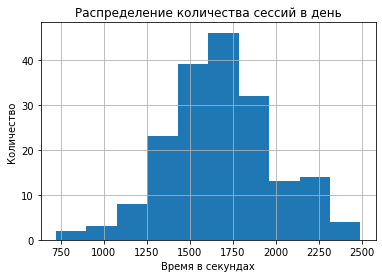

In [28]:
plt.figure(figsize=(14,5)) # не понимаю, почему она то работает то нет
visits.groupby('session_date').agg({'session_date':"count"}).hist()
plt.title('Распределение количества сессий в день')
plt.xlabel('Время в секундах')
plt.ylabel('Количество')

<div class="alert alert-danger">
<b>❌ Комментарий ревьюера:</b> Гистограмма выглядит не очень наглядной. Попробуй построить ее на сгруппированных данных, уменьшив количество bins 

</div>

<div class="alert alert-info"> <b>Комментарий ревьюера:</b> Стало гораздо лучше! Можем еще добавить подпи осей, чтобы понимать, что по оси Х у нас кол-во дневных сессий</div>

-    Сколько длится одна сессия?

In [29]:
#из-за большого количества выбросов среднее сильно смещено по сравнению с медианой
(visits['session_end'] - visits['session_start']).dt.seconds.describe()

count    309901.000000
mean       1800.084801
std        1803.189827
min           0.000000
25%         540.000000
50%        1260.000000
75%        2520.000000
max       22260.000000
dtype: float64

Text(0, 0.5, 'Количество')

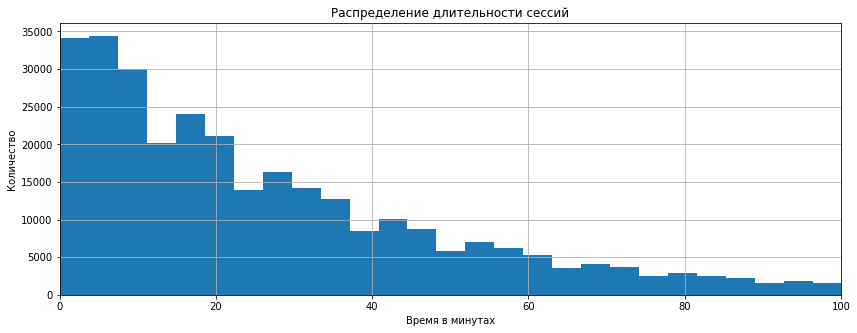

In [30]:
plt.figure(figsize=(14,5))
(((visits['session_end'] - visits['session_start']).dt.seconds) / 60).hist(bins=100) #ничего умнее не придумал )
plt.xlim([0,100])
plt.title('Распределение длительности сессий')
plt.xlabel('Время в минутах')
plt.ylabel('Количество')


**Вывод:**

Средняя продолжительность сессии 30 минут, но большинство пользователей не проводят в игре больше 21 минуты, среднее значение сильно смещено из-за большого количества выбросов. 

### Продажи:

- Когда люди начинают покупать?

In [31]:
first_order = orders[['user_id', 'event_dt']].sort_values(by='event_dt').groupby('user_id').agg({'event_dt': 'first'})
first_order.head()

,event_dt
user_id,
599326,2019-05-07 20:59:09
46006712,2019-06-30 03:46:52
374052872,2019-08-16 07:44:47
414791703,2019-05-04 18:06:41
785077127,2019-06-30 18:35:15


In [32]:
first_profiles = profiles.loc[profiles['payer'] == True][['user_id', 'first_ts']].sort_values(by='first_ts').groupby('user_id').agg({'first_ts': 'first',})
first_profiles.head()

,first_ts
user_id,
599326,2019-05-07 20:58:00
46006712,2019-06-30 03:46:00
374052872,2019-08-08 15:42:00
414791703,2019-05-03 12:01:00
785077127,2019-06-27 08:31:00


In [33]:
(first_order['event_dt'] - first_profiles['first_ts']).dt.days.mean()


1.702510978493413

In [82]:
(first_order['event_dt'] - first_profiles['first_ts']).dt.total_seconds().describe()// 60 # дельта в минутах

count       148.0
mean       2711.0
std        8692.0
min           0.0
25%           0.0
50%           1.0
75%        2128.0
max      190314.0
dtype: float64

Text(0, 0.5, 'Количество покупок')

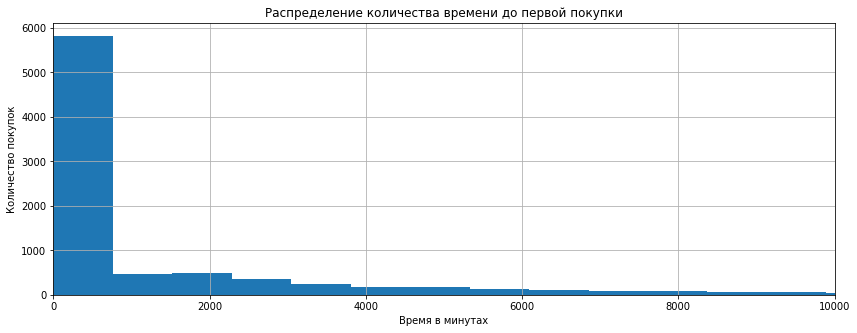

In [35]:
plt.figure(figsize=(14,5))
((first_order['event_dt'] - first_profiles['first_ts']).dt.total_seconds() // 60).hist(bins=250)
plt.xlim([0, 10000])
plt.title('Распределение количества времени до первой покупки')
plt.xlabel('Время в минутах')
plt.ylabel('Количество покупок')

**Вывод:**
Большинство пользователей делают первые покупки за первые 750 минут.

- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?

In [36]:
orders['day'] = orders.event_dt.dt.date
orders['week'] = orders.event_dt.dt.week
orders['month'] = orders.event_dt.dt.month

среднее количество покупок в день у платящих пользователей

In [37]:
num_days = orders.day.nunique()
num_week = orders.week.nunique()
num_month = orders.month.nunique()

In [38]:
mean_purchase = orders.user_id.value_counts().mean()
mean_purchase

4.52786848327891

In [39]:
mean_purchase / num_days

0.024607980887385382

График отражает среднее количество покупок в день

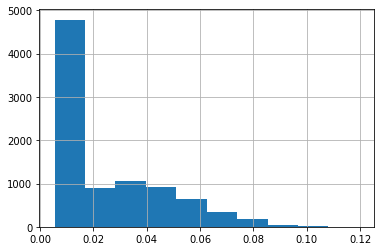

In [40]:
(orders.groupby('user_id').day.nunique() / num_days).hist() #ничего умнее я не придумал

среднее количество покупок в неделю у платящих пользователей

In [41]:
mean_purchase / num_week 

0.1676988327140337

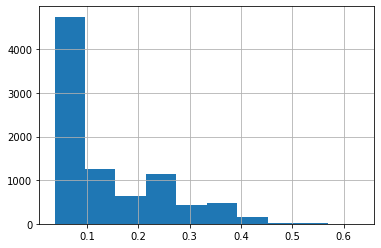

In [42]:
(orders.groupby('user_id').week.nunique() / num_week).hist()

среднее количество покупок в месяц у платящих пользователей

In [43]:
mean_purchase / num_month 

0.7546447472131517

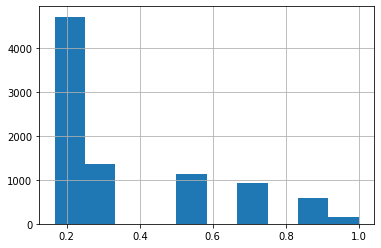

In [44]:
(orders.groupby('user_id').month.nunique() / num_month).hist()

**Вывод:**

из всего вышесделанного я понял, что пользователи делают несколько покупок в один момент и больше никогода, ничего не покупают. Чтобы посчитать среднее количество покупок в день, неделю, месяц надо разделить среднее количество покупок пользователя на количество дней, месяцев и недель.

- Какой средний чек за месяц, неделю, день?

средний чек за день

In [45]:
orders.groupby(['day']).agg({'revenue':'mean'}).mean()

revenue    5.375884
dtype: float64

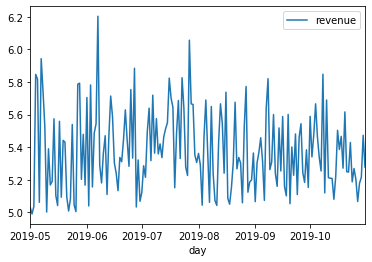

In [46]:
orders.groupby(['day']).agg({'revenue':'mean'}).plot()

средний чек за неделю

In [47]:
orders.groupby(['week']).agg({'revenue':'mean'}).mean()

revenue    5.376336
dtype: float64

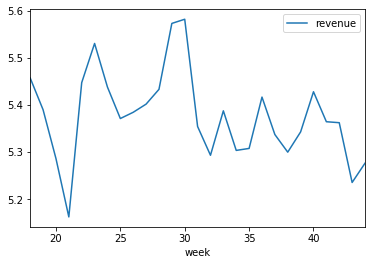

In [48]:
orders.groupby(['week']).agg({'revenue':'mean'}).plot()

средний чек за месяц

In [49]:
orders.groupby(['month']).agg({'revenue':'mean'}).mean()

revenue    5.374169
dtype: float64

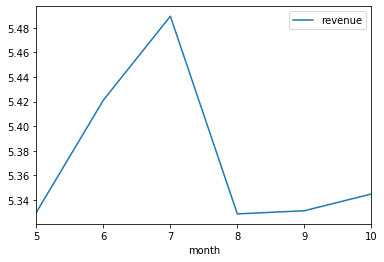

In [50]:
orders.groupby(['month']).agg({'revenue':'mean'}).plot()

**Вывод:**

Со временем значения не слишком меняются, похоже пользователи покупают какую-то подписку и иногда, что-то еще. 

### Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени

Всего потратили

In [51]:
costs.sum()

costs    105497.3
dtype: float64

На каждый источник

In [52]:
costs.groupby('channel').costs.sum()

channel
AdNonSense             3911.25
FaceBoom              32445.60
LeapBob                1797.60
MediaTornado            954.48
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
TipTop                54751.30
WahooNetBanner         5151.00
YRabbit                 944.22
lambdaMediaAds         1557.60
Name: costs, dtype: float64

Text(0.5, 1.0, 'Распределение трат на каждый источник по времени')

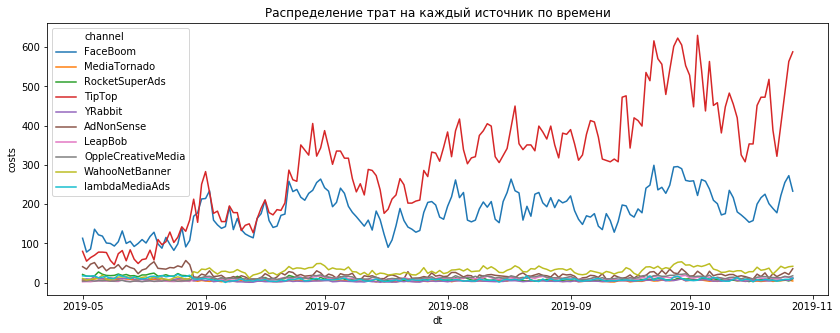

In [53]:
plt.figure(figsize=(14,5))
sns.lineplot(data=costs, x='dt', y='costs', hue='channel').set_title('Распределение трат на каждый источник по времени')


In [54]:
#убираю органиков, дальше они будут только мешать 
profiles = profiles.loc[profiles['channel'] != 'organic']

**Вывод:**

Больше половины денег уходит на один канал TipTop и больше 80% на 2 самых популярных канала. И траты на них со временем только растут.

- Сколько в среднем стоило привлечение одного пользователя из каждого источника?

Создам переменню в которой будут пришедшие пользователи из каждого источника

In [55]:
new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

In [56]:
#TipTop явно выделяется  своей стоимостью привлечения клиентов  

costs.groupby('channel').costs.sum() / new_users.groupby('channel').unique_users.sum()

channel
AdNonSense            1.008054
FaceBoom              1.113286
LeapBob               0.210172
MediaTornado          0.218717
OppleCreativeMedia    0.250000
RocketSuperAds        0.412095
TipTop                2.799003
WahooNetBanner        0.602245
YRabbit               0.218975
lambdaMediaAds        0.724802
dtype: float64

In [57]:
#стоимость привлечения одного клиента
costs.costs.sum() / new_users.unique_users.sum()

1.127481323942759

**Вывод**

Канала на которые потраче больше всего денег являются самыми неэффективными по цене за одного привлеченного пользователя, особенно TipTop

# Шаг 4. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

In [58]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [59]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [60]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [61]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # что мы здесь делаем???
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [62]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # что мы здесь делаем???
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [63]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [64]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [65]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы

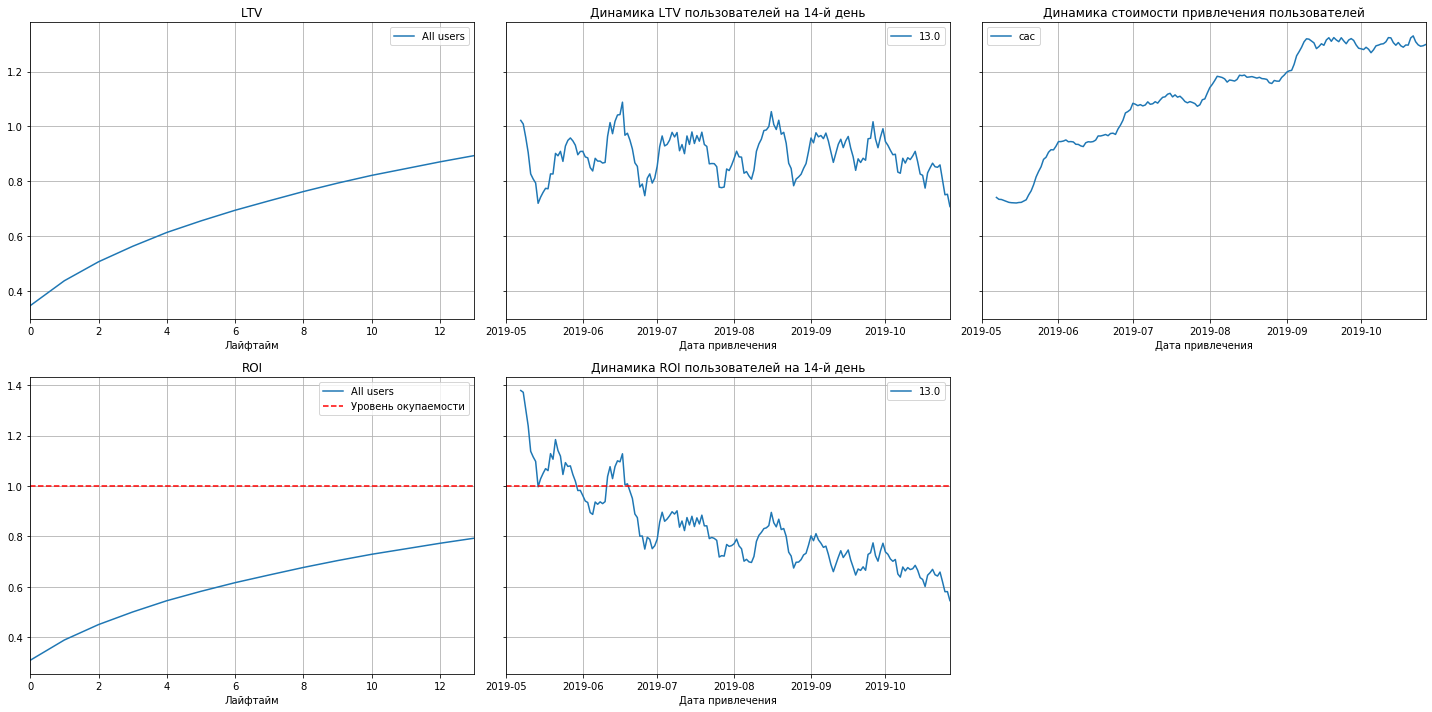

In [66]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, 14
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

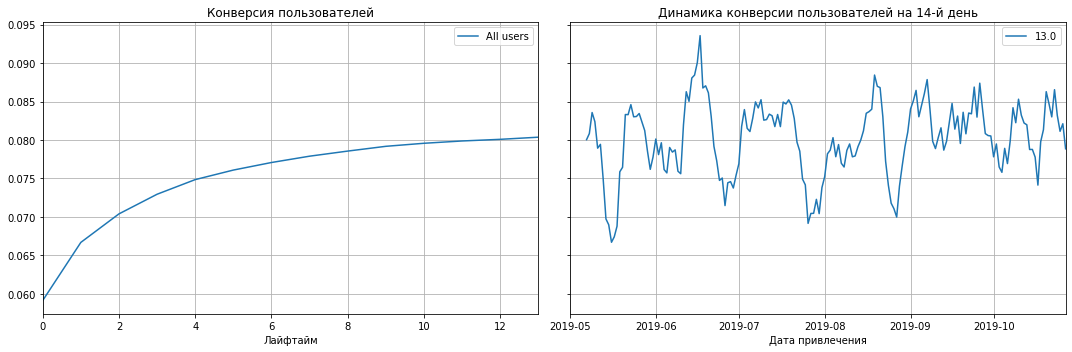

In [67]:

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, 14
)

plot_conversion(conversion_grouped, conversion_history, 14) 

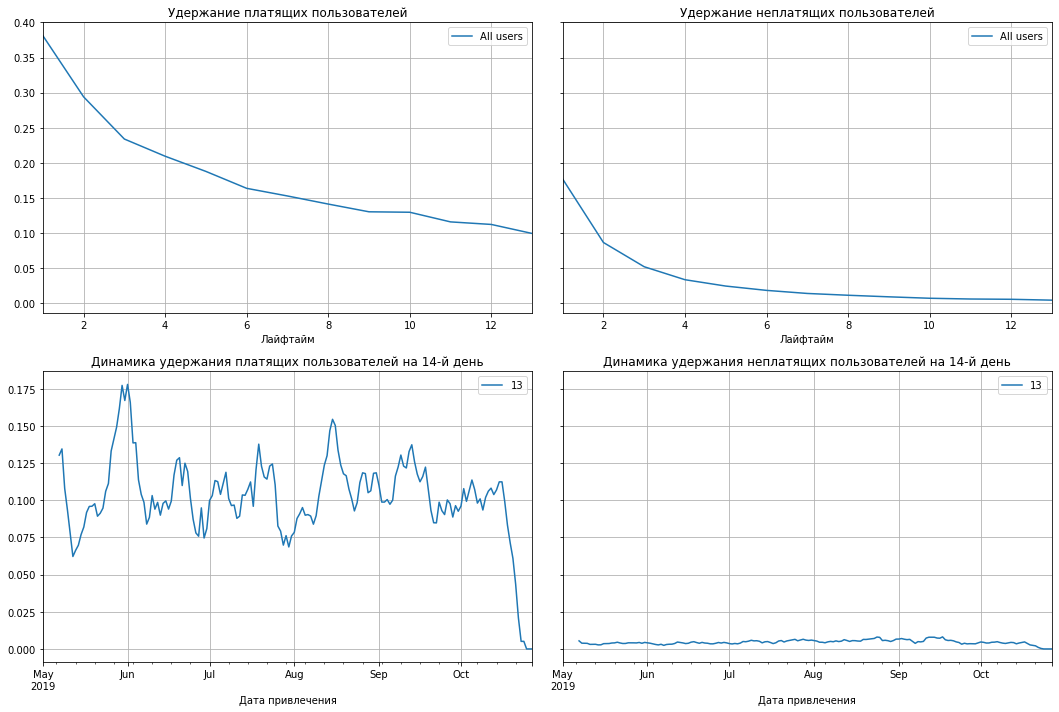

In [68]:

#удержание просто никакое, как я и писал выше пользователи платят один раз и больше никогда ничего не покупают
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, 14
)

plot_retention(retention_grouped, retention_history, 14) 

**Вывод:**

Со временем LTV почти не меняется а вот CAC стабильно растет, поэтому в конце июля реклама окончательно перестала приносить доход. Конверсия, почти не меняет, но это не хорошо и не плохо, А вот удержание неплатящих пользователей практически никакое. Без аудитории ни одно приложение не проживет. 

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

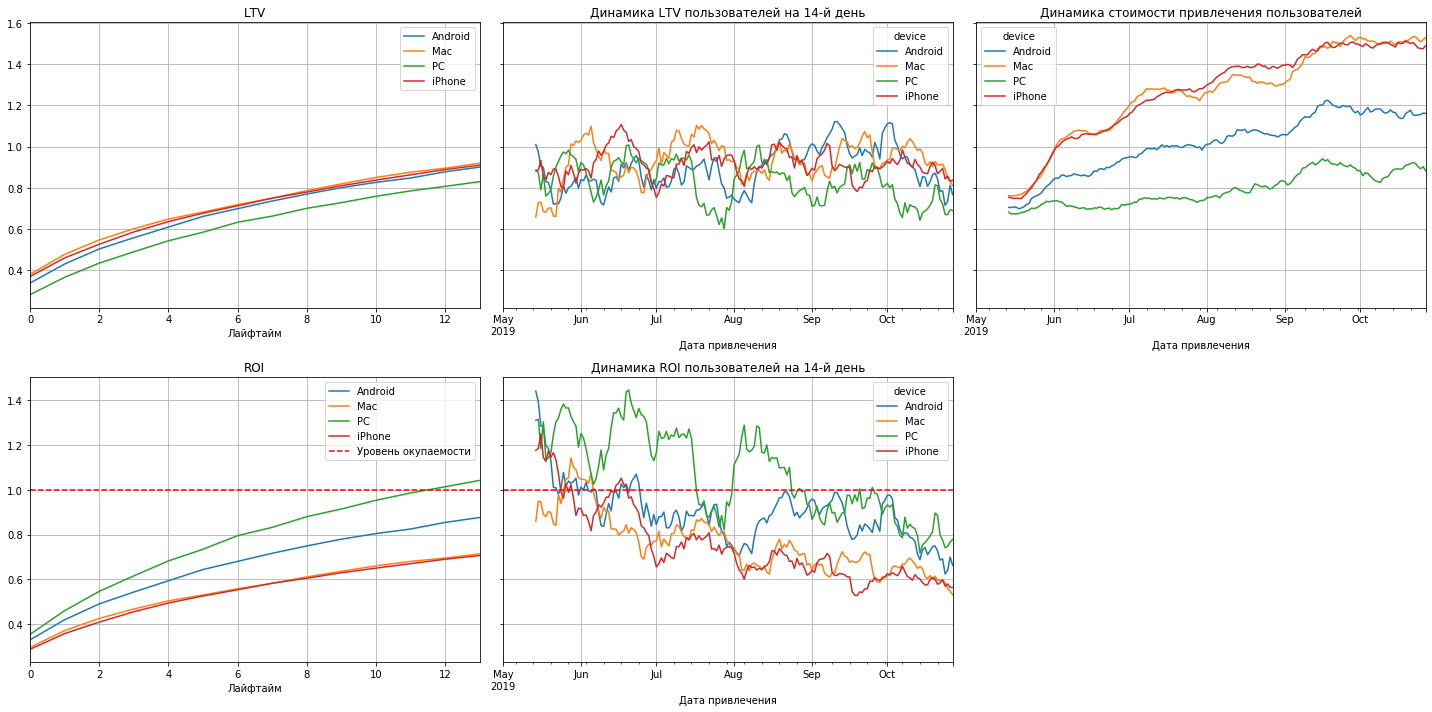

In [69]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, 14, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, 14, window=14
) 

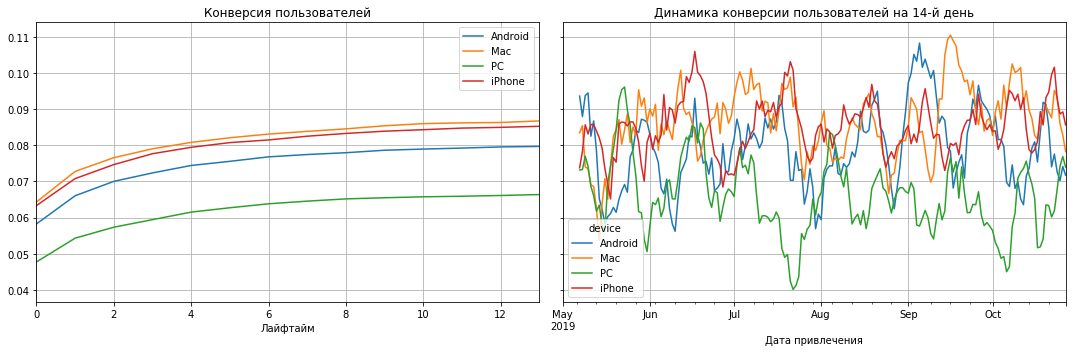

In [70]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, 14, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, 14) 

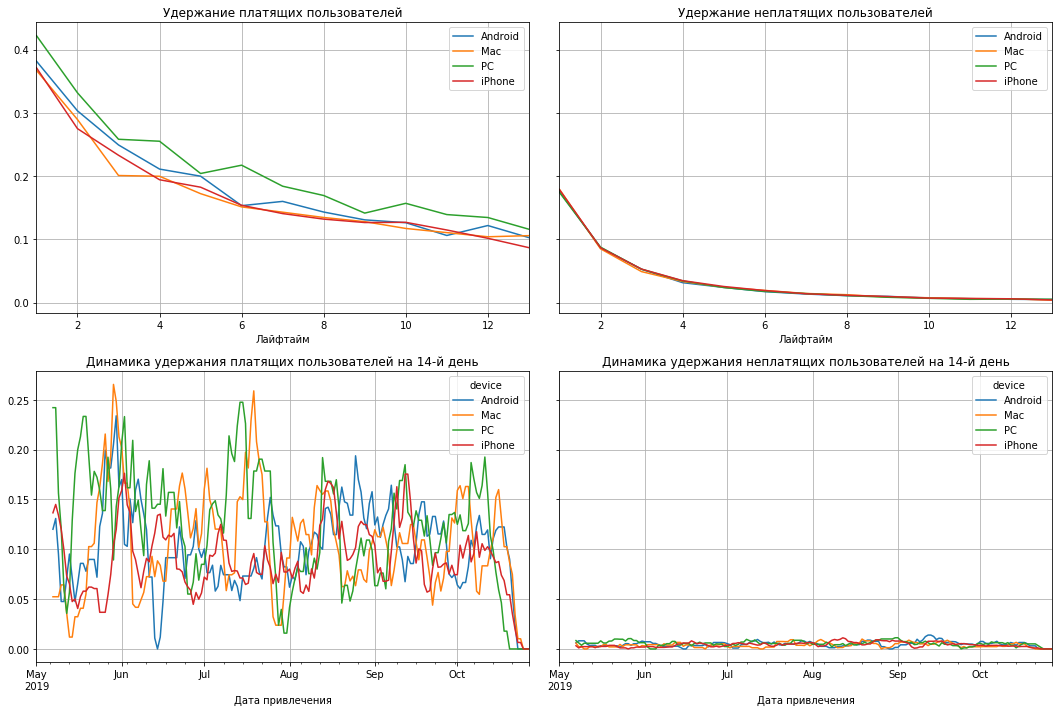

In [71]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, 14, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, 14) 

**Вывод:**

Пользователи пк почти до самого конца приносили прибыль, возможно, стоит тратить больше средств на их привлечение.

### Проанализируйте окупаемость рекламы с разбивкой по странам

Позователи из США самые дорогие, без них реклама бы окупалась

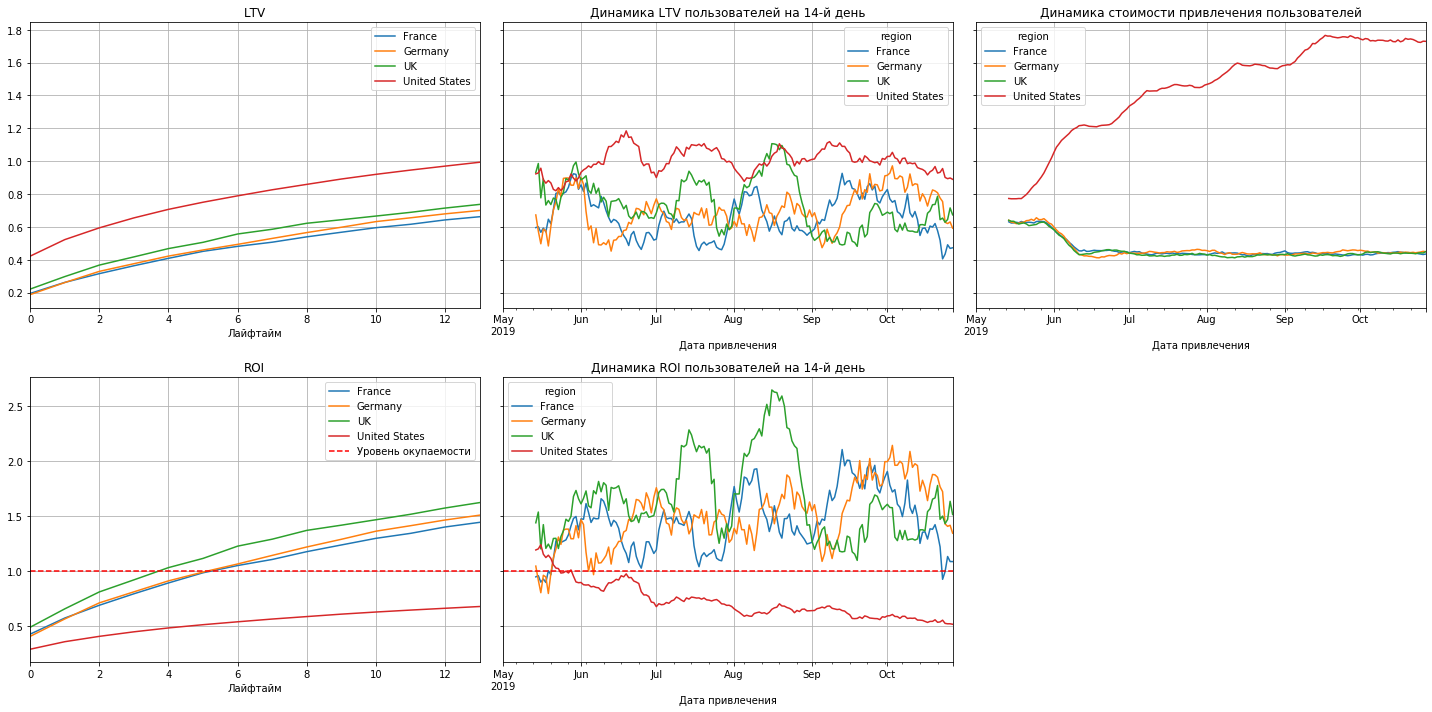

In [72]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, 14, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, 14, window=14
) 

In [73]:

ltv_raw.loc[ltv_raw.region == 'United States'].channel.value_counts()

TipTop            30707
FaceBoom          30321
RocketSuperAds     6264
YRabbit            5304
MediaTornado       5276
Name: channel, dtype: int64

In [74]:
ltv_raw.groupby('region').payer.mean()

region
France           0.232276
Germany          0.234716
UK               0.244953
United States    0.284454
Name: payer, dtype: float64

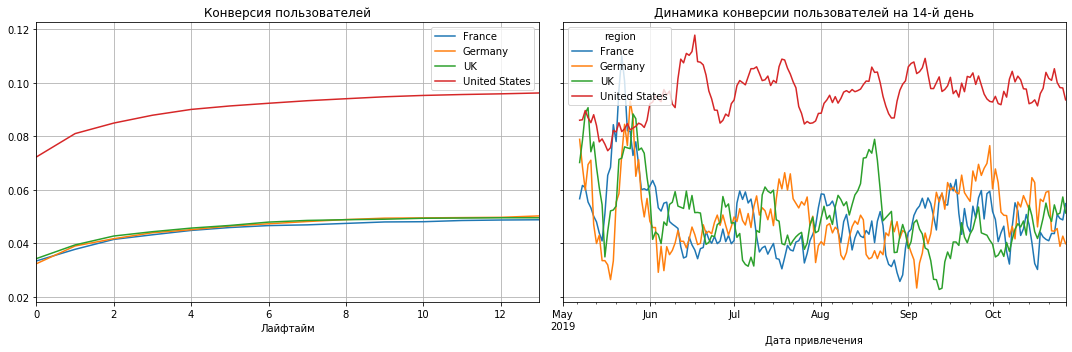

In [75]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, 14, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, 14) 

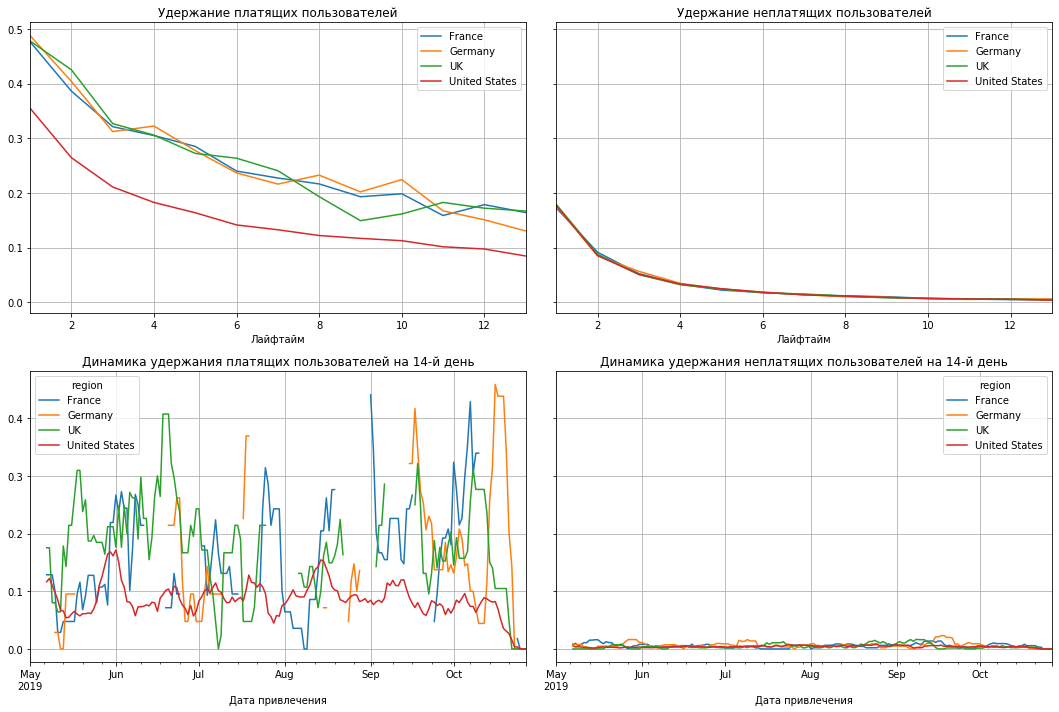

In [76]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, 14, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, 14) 

**Вывод:**

Определенно стоит посмотреть на другие рынки, кроме США. 

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

Tiptop слишком дорогой и неэффективный

In [77]:
profiles.loc[profiles['channel'] == 'TipTop'].region.unique()

array(['United States'], dtype=object)

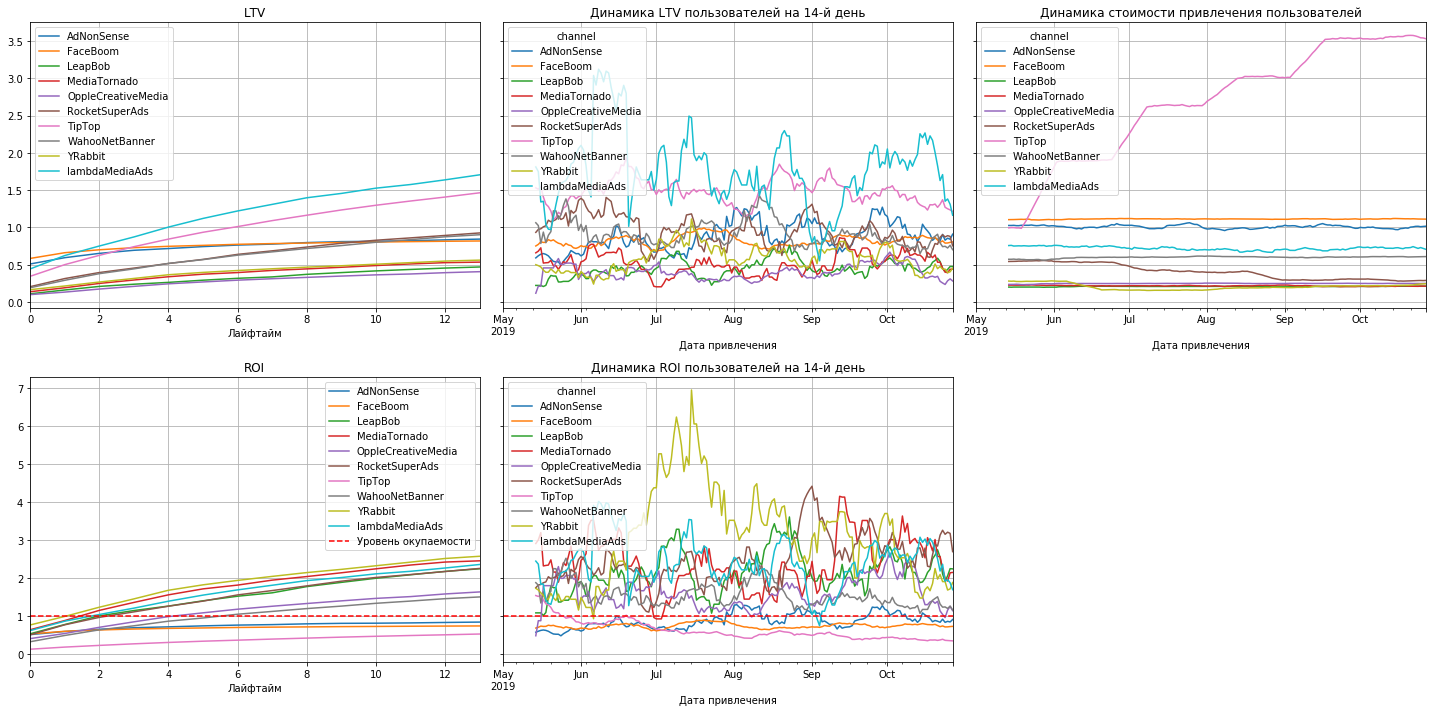

In [78]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, 14, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, 14, window=14
) 

In [79]:
costs.groupby('channel').costs.sum()

channel
AdNonSense             3911.25
FaceBoom              32445.60
LeapBob                1797.60
MediaTornado            954.48
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
TipTop                54751.30
WahooNetBanner         5151.00
YRabbit                 944.22
lambdaMediaAds         1557.60
Name: costs, dtype: float64

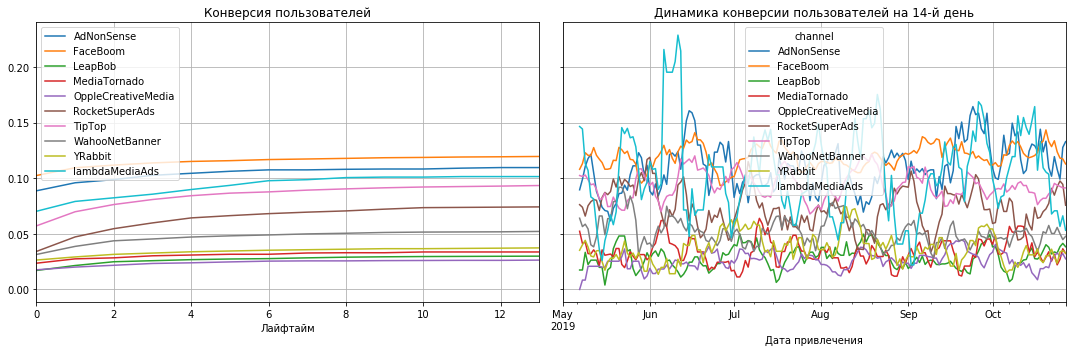

In [80]:
#у TipTop не самая плохая конверсия, но он все равно очень дорогой.
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, 14, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, 14) 

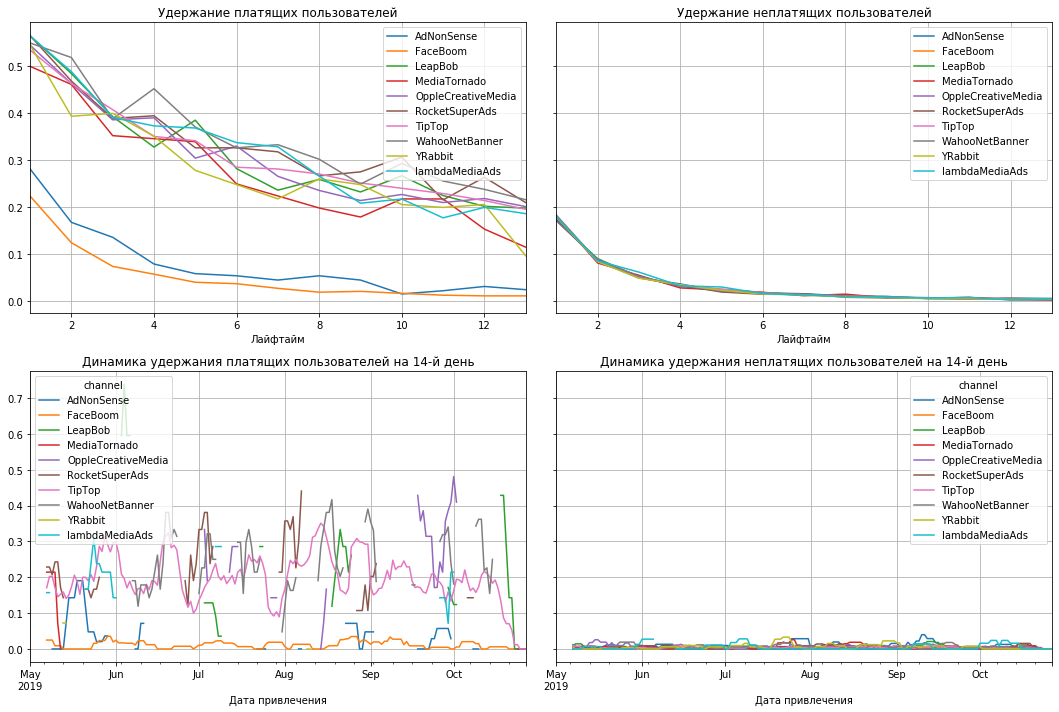

In [81]:

#удержание просто никакое, как я и писал выше пользователи платят один раз и больше никогда ничего не покупают
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, 14, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, 14) 

# Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

**Вывод:**


Реклама TipTop очень неэфективна, а Faceboom просто неэфективна  необходимо перераспределить рекламные бюджеты, и пользоваться более эфективной рекламой. И обратить внимание на другие регионы кроме США. Также можно обратить внимание на другие каналы привлечения пользователей, например lambdaMediaAds у пользователей оттуда самый большой LTV и поэтому довольно большой ROI. Еще можно обратить внимание на YRabbit и MediaTornado, у них не такой высокий LTV, зато стоимость привлечения очень маленькая, поэтому ROI очень большой. 